# Coursework 1 - Decision Trees Learning

### Candidate number: 087074

In [1]:
# Import appropriate packages
import pandas as pd
import numpy as np 
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Load the dataset and split it into descriptive and target datasets
dia_all = pd.read_csv("diabetes.txt")  
sourcevars = dia_all.iloc[:,:-1] 
targetvar = dia_all.iloc[:,-1:] 

In [2]:
dia_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


# Question 1: Exploratory data analysis

### 1a) Calculate the mean, median, standard-deviation and correlation matrix for all the input attributes using Pandas package. 

In [24]:
summary = sourcevars.aggregate([np.mean, np.median, np.std])
summary = summary.round(3)
summary

,preg,plas,pres,skin,insu,mass,pedi,age
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241
median,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760


In [25]:
sourcevars.corr().round(3)

,preg,plas,pres,skin,insu,mass,pedi,age
preg,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544
plas,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264
pres,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240
skin,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114
insu,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042
mass,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036
pedi,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034
age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000


## 1b) Draw a chart that helps with understanding the data. 

In [26]:
# Function that returns a normalised version of a dataset
def normalise(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        # Use Min-Max technique
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [27]:
# A function that returns the column headers of a dataset as a list
def get_labels(dataframe):
    labels = []
    for col in dataframe:
        labels.append(col)
    return labels

In [28]:
# Normalise the dataset and get the column headings
Normalised_source = normalise(sourcevars)
labels = get_labels(sourcevars)

# Create a new normalised datadrame and add the target variable to it
Normalised_data = pd.DataFrame(Normalised_source, columns = labels)
target = targetvar['class'].astype(str)
Normalised_data['class'] = target

# Split the observations in the dataset by their classification category and calculate the means for each characteristic in both categories
Normal_negative = Normalised_data.loc[Normalised_data['class'] == 'tested_negative'].aggregate([np.mean])
Normal_positive = Normalised_data.loc[Normalised_data['class'] == 'tested_positive'].aggregate([np.mean])
Normal_means_positive = Normal_positive.iloc[0,:].to_numpy()
Normal_means_negative = Normal_negative.iloc[0,:].to_numpy()

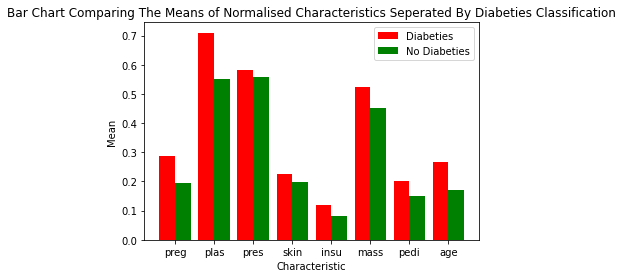

In [29]:
# Plot a bar chart showing the data
x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Normal_means_positive, width, label='Diabeties', color ='r')
rects2 = ax.bar(x + width/2, Normal_means_negative, width, label='No Diabeties',color ='g')

ax.set_ylabel('Mean')
ax.set_xlabel('Characteristic')
ax.set_title('Bar Chart Comparing The Means of Normalised Characteristics Seperated By Diabeties Classification')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Question 2: Classification

### 2a) Build a Decision Tree classifier using the training dataset and evaluate the performance on the testing set. Repeat this experiment 10 times using a different random split in each iteration. Show the performance (i.e. accuracy, true positive rate and precision) for each iteration and the average of the 10 iterations for each measure.  

In [30]:
# Import appropriate machine learning software
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [31]:
# A function that ouputs the Specifity, Accuracy, Sensitivity and Precision of a model
def performance(target, predicted):
    cm = confusion_matrix(target, predicted)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    TOT = TP+FP+FN+TN
    # Specificity
    SPE = TN/(TN+FP)
    # Accuracy 
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    return ACC, TPR, PPV, SPE

In [32]:
# Create empty lists that will store the performance indicators of the model
ACC_list = []
TPR_list = []
PPV_list = []
SPE_list = []

# Find the predictions of the model, iterating 10 times with a random split each time 
for i in range(1,11):
    source_train, source_test, target_train, target_test = train_test_split(sourcevars, targetvar, test_size = 0.3, random_state = i)
    # Use the Gini Index as the criterion for quality of node split 
    classifier_model = DecisionTreeClassifier(criterion="gini", random_state=1)
    classifier_model = classifier_model.fit(source_train, target_train)
    prediction = classifier_model.predict(source_test)
    # Store the performance of the model for each iteration
    ACC, TPR, PPV, SPE = performance(target_test, prediction)
    ACC_list.append(ACC)
    TPR_list.append(TPR)
    PPV_list.append(PPV)
    SPE_list.append(SPE)

# Create a dataframe with the key performance indicators of the model for each iteration
dict = {'Accuracy': ACC_list, 'Precision': PPV_list, 'Sensitivity': TPR_list, 'Specificity': SPE_list}
df = pd.DataFrame(dict)
df.loc['mean'] = df.mean() # Add a row with the means
df = df.round(3)
df

,Accuracy,Precision,Sensitivity,Specificity
0,0.688,0.589,0.506,0.795
1,0.680,0.516,0.434,0.800
2,0.649,0.605,0.500,0.759
3,0.697,0.553,0.595,0.750
4,0.727,0.551,0.606,0.781
5,0.706,0.558,0.615,0.752
6,0.714,0.615,0.571,0.796
7,0.710,0.602,0.595,0.776
8,0.688,0.554,0.568,0.753
9,0.710,0.632,0.552,0.806


### 2b) Compare the performance of the experiment above when you change the criterion from Gini impurity (“gini”) to information gain (“entropy”). Repeat this experiment 10 time using a different random split in each iteration as in section in part (a)

In [33]:
# Create empty lists that will store the performance indicators of the model
ACC_list2 = []
TPR_list2 = []
PPV_list2 = []
SPE_list2 = []

# Find the predictions of the model, iterating 10 times with a random split each time 
for i in range(1,11):
    source_train, source_test, target_train, target_test = train_test_split(sourcevars, targetvar, test_size = 0.3, random_state = i)
    # Use Information Gain as the criterion for quality of node split 
    classifier_model2 = DecisionTreeClassifier(criterion="entropy", random_state=1)
    classifier_model2 = classifier_model2.fit(source_train, target_train)
    prediction2 = classifier_model2.predict(source_test)
    # Store the performance of the model for each iteration
    ACC, TPR, PPV, SPE = performance(target_test, prediction2)
    ACC_list2.append(ACC)
    TPR_list2.append(TPR)
    PPV_list2.append(PPV)
    SPE_list2.append(SPE)

# Create a dataframe with the key performance indicators of the model for each iteration
dict2 = {'Accuracy': ACC_list2, 'Precision': PPV_list2, 'Sensitivity': TPR_list2, 'Specificity': SPE_list2}
df2 = pd.DataFrame(dict2)
df2.loc['mean'] = df2.mean() # Add a row with the means
InfoGain_means = df2.mean()
df2 = df2.round(3)
df2

,Accuracy,Precision,Sensitivity,Specificity
0,0.736,0.636,0.659,0.781
1,0.684,0.521,0.500,0.774
2,0.671,0.631,0.541,0.767
3,0.714,0.576,0.620,0.763
4,0.688,0.495,0.648,0.706
5,0.736,0.610,0.603,0.804
6,0.749,0.659,0.643,0.810
7,0.706,0.598,0.583,0.776
8,0.701,0.581,0.531,0.793
9,0.710,0.628,0.563,0.799


### 3c) Compare the performance of the two classifiers (a) and (b) over the 10 repeats using a suitable chart. 

In [34]:
# Create a dataframe that compares the means of the key performance indicators for the two classifiers in (a) and (b)
Comparison_dict = {'Gini': df.mean(), 'Information Gain': df2.mean()}
Comparison_table = pd.DataFrame(Comparison_dict)
Comparison_table = Comparison_table.round(3)

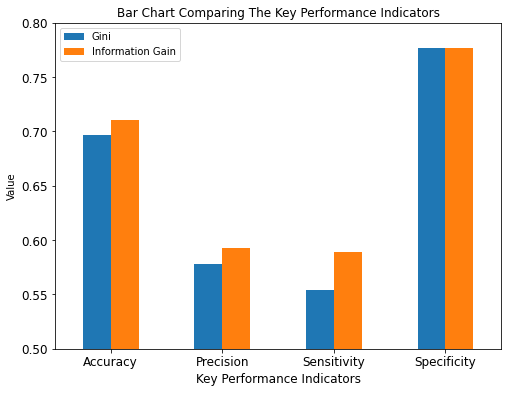

In [35]:
# Plot the information of the dataframe on a bar chart
ax = Comparison_table[['Gini','Information Gain']].plot(kind='bar', title ="Bar Chart Comparing The Key Performance Indicators", figsize=(8, 6), legend=True, fontsize=12)
ax.set_xlabel("Key Performance Indicators", fontsize=12)
ax.set_ylabel("Value")
plt.xticks(rotation=0)
ax.set_ylim([0.5,0.8])
plt.show()

### 3d) Do you think standardizing the data before applying DT would improve the performance for this dataset? Why? (150 words)

The performance of a decision tree isn’t affected by standardising the dataset. When a dataset is standardised, a linear transformation is applied to each of the values to remove the units which doesn’t change the ordering of the observations for each characteristic. A dataset is split by setting threshold levels on a characteristic designed to maximise the quality of a node split, therefore the standardised threshold levels will split the standardised dataset at the same points that threshold levels set on the unstandardised dataset would. Therefore, the standardised and the unstandardised datasets would be split into the same subgroups. This is true for each node in a decision tree, resulting in identical decision trees and thus performance of standardised and unstandardised data.

# Question 3: DT Classification parameters

### 3a) How does increasing the minimum number of samples required to split an internal node parameter in the DT algorithm (i.e. min_samples_split = 2, 5, 10 and 15) affect the accuracy on the test set? Show your results using a suitable chart or table.

In [36]:
import statistics

# Create empty lists that will store the minimum sample splits and the accuracy
ACC_MinSplit = []
MinSampleSplit = []

for h in range(2,250): # Iterate up to 250 minimum sample splits as this is where the model tends to a stationary value
    source_train, source_test, target_train, target_test = train_test_split(sourcevars, targetvar, test_size = 0.3, random_state = 1)
    # Change the minimum sample split
    classifier_model3 = DecisionTreeClassifier(criterion="entropy", random_state=1, min_samples_split = h)
    classifier_model3 = classifier_model3.fit(source_train, target_train)
    prediction3 = classifier_model3.predict(source_test)
    # Calculate the performance of each model
    ACC, TPR, PPV, SPE = performance(target_test, prediction3)
    MinSampleSplit.append(h)
    ACC_MinSplit.append(ACC)

# Create and display a dateframe storing the information
dict31 = {'Minimum Sample Split': MinSampleSplit, 'Accuray': ACC_MinSplit}
df31 = pd.DataFrame(dict31)

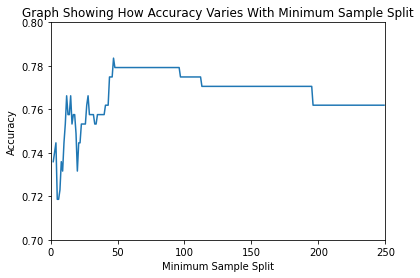

In [37]:
# Plot the information on a line graph
df31.plot(x ='Minimum Sample Split',y ='Accuray', kind = 'line')
plt.xlabel('Minimum Sample Split')
plt.ylabel('Accuracy')
plt.title('Graph Showing How Accuracy Varies With Minimum Sample Split')
plt.legend('',frameon=False)
axes = plt.gca()
axes.set_xlim([0,250])
axes.set_ylim([0.7,0.8])
plt.show()

### 3b) How does increasing the maximum depth of the decision tree parameter (i.e. max_depth = 3, 4, 5 and 6) affect the accuracy on the test set? Show your results using a suitable chart or table. 

In [38]:
# Create empty lists that will store the minimum maximum tree depth and the accuracy
ACC_MaxDepth = []
MaxDepth = []

for h in range(1,25): #  Iterate up to 250 minimum sample splits as this is where the model tends to a stationary value
    source_train, source_test, target_train, target_test = train_test_split(sourcevars, targetvar, test_size = 0.3, random_state = 1)
    # Change the maximum tree depth
    classifier_model4 = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth = h)
    classifier_model4 = classifier_model4.fit(source_train, target_train)
    prediction4 = classifier_model4.predict(source_test)
    # Calculate the performance of each model
    ACC, TPR, PPV, SPE = performance(target_test, prediction4)
    MaxDepth.append(h)
    ACC_MaxDepth.append(ACC)

# Create and display a dateframe storing the information
dict4 = {'Maximum Depth': MaxDepth, 'Accuray': ACC_MaxDepth}
df4 = pd.DataFrame(dict4)

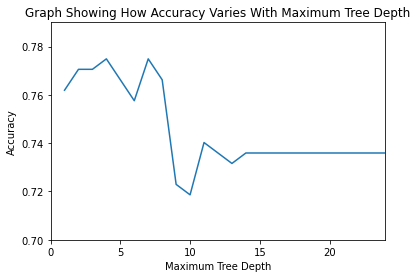

In [39]:
# Plot the information on a line graph
df4.plot(x ='Maximum Depth', y='Accuray', kind = 'line')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.title('Graph Showing How Accuracy Varies With Maximum Tree Depth')
plt.legend('',frameon=False)
axes = plt.gca()
axes.set_xlim([0,24])
axes.set_ylim([0.7,0.79])
plt.show()